In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Character Level Dinousaur Names Generator with Keras

## Import packages

In [2]:
import numpy as np 
import sys 

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN #Dropout, LSTM, Activation, 
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

## Load data

In [3]:
#Open file with dinosaurs names
data = open('../data/dinos.txt','r').read()
data = data.lower()

#Create a list of the characters that appear on the names, and a list of the names themselves
chars = sorted(list(set(data)))
vocab_size = len(chars)
examples = data.split('\n')

max_len = 0
for name in examples:
    if len(name) > max_len:
        max_len = len(name)
        
max_len

print('There are %d dinosaur names and %d unique characters in your data. The longest dinosaur name has %d characters.\n' % (len(examples), vocab_size, max_len))
print(chars)

There are 1537 dinosaur names and 27 unique characters in your data. The longest dinosaur name has 26 characters.

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Data processing

In [4]:
#Create dictonaries that allow to code characters into integers and viceversa
char_to_id = {ch:i for i,ch in enumerate(chars)}
id_to_char = {i:ch for i,ch in enumerate(chars)}

In [5]:
def name_to_ints(name): #Given a dinosaur name, returns a list with the corresponding encoding into integers of each character 
    int_list = []
    for c in name:
        int_list.append(char_to_id[c])
    
    for i in range(max_len-len(int_list)):
        int_list.append(0)
        
    return int_list

In [6]:
def ints_to_onehot(int_list): #Given a list of integers, returns a matrix where each column corresponds to the one-hot encoding of the corresponding integer
    X = np.zeros((vocab_size,len(int_list)))
    for j,i in enumerate(int_list):
        if int_list[j] != None:
            X[i][j] = 1
        
    return X  

In [7]:
def devectorize_example(example): #Given a one-hot encoding matrix of a word, translate the matrix into the corresponding word and prints the result
    result = [id_to_char[np.argmax(vec)] for vec in example]
    return ''.join(result)

In [8]:
X = np.zeros((len(examples),vocab_size,max_len+1))
for i,name in enumerate(examples):
    int_list = name_to_ints(name)
    int_list.insert(0,None)
    X[i] = ints_to_onehot(int_list)
    
X = X.transpose([0,2,1])

In [9]:
Y = np.zeros((len(examples),vocab_size,max_len+1))
for i,name in enumerate(examples):
    int_list = name_to_ints(name)

    

    int_list.append(0)
   
        
    Y[i] = ints_to_onehot(int_list)
    
Y = Y.transpose([0,2,1])

In [10]:
ex_id = 1280
devectorize_example(X[ex_id]), devectorize_example(Y[ex_id])

('\nstaurikosaurus\n\n\n\n\n\n\n\n\n\n\n\n',
 'staurikosaurus\n\n\n\n\n\n\n\n\n\n\n\n\n')

## Model

In [11]:
def create_model():
    model = Sequential(
        [
            Input(shape = (None,vocab_size)),
            SimpleRNN(units = 100, return_sequences = True, kernel_regularizer = regularizers.l2(1e-4)),
            Dense(units = vocab_size, activation = 'softmax')
        ]
    )
    
    model.summary()
    
    return model
    

In [12]:
def generate_name(model):#Use the model to create a new dinosaur name
    name = ''
    i = 0
    c = ''
    x_input = np.zeros((1,27,vocab_size))
    while(c!='\n' and i<26):
        probs = model.predict(x_input)[0,i].reshape((27,))
        idx = np.random.choice(range(len(probs)), p = probs)
        c = id_to_char[idx]
        name = name + c
        i = i+1
        x_input[0,i,idx] = 1
         
    return name[:-1] 

def print_n_names(model, n, e): #Print n names using the model trained up to epoch e
    print('\n\nExamples on epoch ' + str(e))
    for i in range(n):
        print(generate_name(model))
    
def show_results(model): #Show a list of 10 examples of generated names after training
    for i in range(10):
        print('--- ' + generate_name(model))
        
def plot_train_metric(history, metric = "accuracy", 
                      loc = "lower right", tic_freq = 5):
    
    p1, = plt.plot(history.history[metric], label = metric);
    p2, = plt.plot(history.history["val_" + metric], label = "val_" + metric);
    plt.xlabel("Epoch")
    plt.ylabel(metric.title())
    plt.title(f"{metric.title()} v.s. epoch")
    plt.legend(handles = [p1, p2], loc = loc)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(tic_freq))

In [13]:
def fit_model(use_el = False):
    model = create_model()
    
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001,clipvalue = 10)
    print_examples = LambdaCallback(on_epoch_end = lambda e,l: print_n_names(model,5,e), end = '\n\n')
    model.compile(optimizer=opt,loss = 'categorical_crossentropy', metrics = ['accuracy'])
    el = EarlyStopping(monitor = 'val_loss', patience = 5)
    
    if(use_el == False):
        history = model.fit(X, Y, epochs = 100, batch_size = 32, shuffle=True, validation_split = 0.2,  
                    callbacks = [print_examples], verbose = False)
        
    else:
        history = model.fit(X, Y, epochs = 100, batch_size = 32, shuffle=True, validation_split = 0.2,  
                    callbacks = [print_examples, el], verbose = False)
        
    return model, history

## Version 1

In [14]:
model, history = fit_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 100)         12800     
_________________________________________________________________
dense (Dense)                (None, None, 27)          2727      
Total params: 15,527
Trainable params: 15,527
Non-trainable params: 0
_________________________________________________________________


Examples on epoch 0
urs
bqirbaourrasr
fvyisauryo
odzynbnidlur
rbjdass


Examples on epoch 1

vygkblpaarlo
fplcvuninusxlret
qnqsiuhvei
gnies


Examples on epoch 2
iviodaaot
esopaorap
goattaeeubps
xvlbiauatanxg
xc


Examples on epoch 3
cmnousauslclu
tlfnteidur
oghatacsaurana
rvonaordh
txran


Examples on epoch 4
vvurantosaxnui
pazensaurus
ergensaon

ftodiusu


Examples on epoch 5
xbrlirosi
xflxious
juvaitaloogsau
ilorotooa
vcr


Examples on epoch 6
reithus
xwhilaon
epaeovonagpr
rtseihrsauiu
tohailbratras


Ex

eltihusaurus
chyxpaleos
psellosaurus


Examples on epoch 89
chyloalaptlly
bellegasturus
shilomo
dgnmwhus
iganeosaurus


Examples on epoch 90
insaromimosaurus
prooropiscur
noprotrentos
borangosaurus
leuskusaurus


Examples on epoch 91
jernadosaurus
aukutapaltn
sarurtotetatlis
osiophovis
achindosaurus


Examples on epoch 92
parcaodon
nidwyasaurus
lonszunasaurus
hanxosaurinosaurubus
saraiblasaurus


Examples on epoch 93
alitania
bidocosaurus
bericoveraus
canirasaurus
gusiceitonsufr


Examples on epoch 94
maraorhonos
caucterisaurus
derspresaurus
copiterua
draverosaurus


Examples on epoch 95
luapantys
dronychononoron
panphosaurus
alloros
drostoran


Examples on epoch 96
sanshenosaurus
iscryanopatlo
junntgropa
arshaeornyx
arphadan


Examples on epoch 97
erocondin
eurusjursivis
cheonkonsaurapton
maguensaurus
disnohus


Examples on epoch 98
komwynngkin
drocmpholeshuros
dolacora
aptodocntheis
saramasaurus


Examples on epoch 99
camptosaurus
kolepadomi
praptosaurus
brchisarcau
heglengsaurus


In [15]:
show_results(model)

--- braxilasaurus
--- lethemiruin
--- kuavucematops
--- hazpolvenhtesa
--- konitenamic
--- kuapksaerus
--- gongaus
--- caplophoris
--- haelisaurus
--- vurater


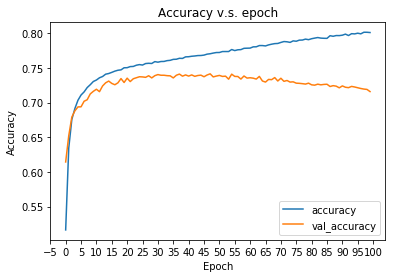

In [16]:
plot_train_metric(history, metric = "accuracy")

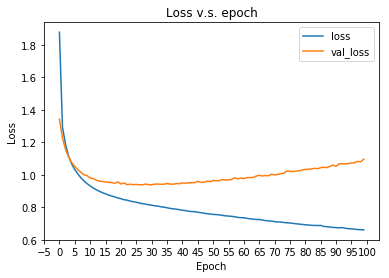

In [17]:
plot_train_metric(history, metric = "loss", loc = "upper right")

In [18]:
model.save_weights("../models/AleconH_model_v1.h5")
print('Model saved!')

Model saved!


## Version 2: with early stopping

In [19]:
model, history = fit_model(use_el = True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 100)         12800     
_________________________________________________________________
dense_1 (Dense)              (None, None, 27)          2727      
Total params: 15,527
Trainable params: 15,527
Non-trainable params: 0
_________________________________________________________________


Examples on epoch 0
putiokygrurri
vg
qbqcpiodzaeams
zplgjuawtsaa
jkjndsnar


Examples on epoch 1
nfisvyrhookuo
rdzlroauajs
nqhwasoonosaur
nkezrlrijr



Examples on epoch 2
fatbconamrae
anrwsa
jtgonaorhsu
wl
livuis


Examples on epoch 3
rorotrhsn
yprcptinasauluf
ztenntooeia
ypvmodikho
mpelnsaigm


Examples on epoch 4
vedoalunu
dnyloeonan
nvperosaurasha
uprnnalmcrira
oxyalrrs


Examples on epoch 5
kcymteoeus
equjerojeus
vsaprosourus
bebaroesauruu
cerlanonunujus


Examples on epoch 6
peitepadohu
craaltorusas

In [20]:
show_results(model)

--- comihus
--- kolepatopa
--- plidonacerasishusus
--- vinator
--- nacoratces
--- ptocenosaurus
--- ryingasaurus
--- iautgritaur
--- leptoropaptos
--- dropneveneosaurus


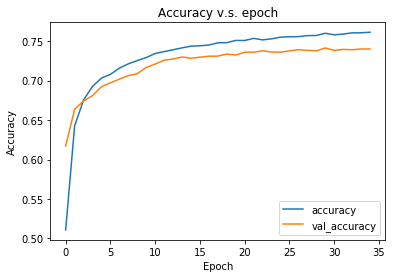

In [21]:
plot_train_metric(history, metric = "accuracy")

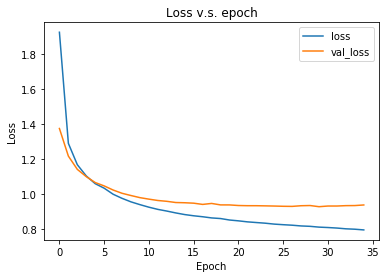

In [22]:
plot_train_metric(history, metric = "loss", loc = "upper right")

In [23]:
model.save_weights("../models/AleconH_model_v2.h5")
print('Model saved!')

Model saved!


## Load a model and generate names

In [24]:
def load_trained_model(weights_path):
    model = create_model()
    model.load_weights(weights_path)
    
    return model

In [25]:
path = '../models/AleconH_model_v1.h5' #change this to load a different model
model = load_trained_model(path)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 100)         12800     
_________________________________________________________________
dense_2 (Dense)              (None, None, 27)          2727      
Total params: 15,527
Trainable params: 15,527
Non-trainable params: 0
_________________________________________________________________


In [26]:
show_results(model)

--- aplosaurus
--- dramolysaurus
--- dorwutasaurus
--- dragyhagonomus
--- oggosaurus
--- dianirantos
--- dacelltusuicosaurus
--- batausauros
--- atragoapaton
--- kaleus
